In [52]:
import sys, importlib
import numpy as np, pandas as pd
print('py:', sys.executable)
print('numpy:', np.__version__, 'pandas:', pd.__version__)
print('numpy.rec spec:', importlib.util.find_spec('numpy.rec'))
print('numpy.core.records spec:', importlib.util.find_spec('numpy.core.records'))

py: /Users/kimjinseok/Desktop/metacode-lecture/.venv/bin/python
numpy: 1.26.4 pandas: 2.3.2
numpy.rec spec: None
numpy.core.records spec: ModuleSpec(name='numpy.core.records', loader=<_frozen_importlib_external.SourceFileLoader object at 0x11046ebd0>, origin='/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/numpy/core/records.py')


In [53]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# 전역 경고 억제 (미래/폐기 예정 경고 및 폰트 경고 노이즈 제거)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

# 노트북 전체 표시 옵션
pd.set_option('display.max_columns', 50)

## Chapter 2-3, 2-2강 시계열 예측 모델링 — PyTorch LSTM (Bike Sharing)

- **목표**: 시계열을 시퀀스 형태로 변환하고 LSTM으로 예측 학습/평가합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn X), 색상 지정 X, 서브플롯 X


### 0. 환경 준비 및 라이브러리 임포트
- PyTorch LSTM 구현 (GPU 없어도 CPU에서 동작)
- 재현성을 위한 시드 고정


In [54]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def _set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



### 1. 데이터 준비 및 전처리
- `bike-sharing-demand/train.csv` 로드, 시간 파생변수 생성
- train/val/test 시간 분할


In [55]:
def load_hourly_data():
    path = '/Users/kimjinseok/Desktop/metacode-lecture/bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv 경로를 찾을 수 없습니다.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


def build_feature_matrix(df: pd.DataFrame):
    feature_cols = ['temp','atemp','humidity','windspeed','season','holiday','workingday','weather','year','month','dayofweek','hour']
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df['count'].astype(np.float32).to_numpy()
    return X, y, feature_cols


df = load_hourly_data()
print('데이터 크기:', df.shape, '기간:', df['datetime'].min(), '→', df['datetime'].max())
df = add_time_features(df)
# 결측치 보간: 먼저 forward-fill, 남은 값은 back-fill
df = df.ffill().bfill()
train_df, val_df, test_df = split_by_time(df)


데이터 크기: (10886, 12) 기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00


### 2. 시퀀스 데이터셋 생성 및 LSTM 모델 정의
- 윈도우 크기 24(하루)로 시퀀스 구성, horizon=1
- 단순 LSTM 회귀 헤드


In [56]:
def make_windows(X: np.ndarray, y: np.ndarray, window: int, horizon: int = 1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon])
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)


### 3. 학습/검증/테스트
- 표준화: train 기준 평균/표준편차
- 학습: Adam + MSE, 베스트 모델 선택
- 예측 vs 실제 시각화


In [57]:
# 클래스 없이 사용할 LSTM 헬퍼 정의

def make_lstm_pair(input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.1, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout,
    ).to(device)
    head = nn.Linear(hidden_size, 1).to(device)
    return lstm, head, device


def lstm_forward(lstm: nn.LSTM, head: nn.Linear, x: torch.Tensor) -> torch.Tensor:
    out, _ = lstm(x)
    last = out[:, -1, :]
    return head(last).squeeze(-1)



In [ ]:
def train_model(model, train_loader, val_loader, epochs: int, lr: float, device):
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)
    patience = 8
    no_improve = 0
    best_val = float('inf')
    best_state = None
    for ep in range(1, epochs+1):
        model.train()
        tr_sum, n = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step()
            tr_sum += float(loss.item()) * len(xb)
            n += len(xb)
        tr_loss = tr_sum / max(n, 1)

        model.eval()
        with torch.no_grad():
            va_sum, n2 = 0.0, 0
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                va_sum += float(loss.item()) * len(xb)
                n2 += len(xb)
        va_loss = va_sum / max(n2, 1)
        print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
        scheduler.step(va_loss)
        if va_loss + 1e-9 < best_val:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
                break
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)


def predict_all(model, loader, device):
    model.eval()
    outs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            pred = model(xb)
            outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)


def plot_series(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 데이터 구성 및 학습
# 3가지 개선 적용: 주간 창(168), 시간 원형 인코딩, 로그 타깃

def add_cyclical_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['hour_sin'] = np.sin(2*np.pi*out['hour']/24)
    out['hour_cos'] = np.cos(2*np.pi*out['hour']/24)
    return out

train_df = add_cyclical_cols(train_df)
val_df   = add_cyclical_cols(val_df)
test_df  = add_cyclical_cols(test_df)

X_train, y_train, feat_cols = build_feature_matrix(train_df)
X_val,   y_val,   _         = build_feature_matrix(val_df)
X_test,  y_test,  _         = build_feature_matrix(test_df)

# 시간 원형 인코딩을 X에 추가(기존 함수는 수정하지 않고 배열에 이어붙임)
def append_cols(X: np.ndarray, df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return np.concatenate([X, df[cols].to_numpy(dtype=np.float32)], axis=1)

X_train = append_cols(X_train, train_df, ['hour_sin','hour_cos'])
X_val   = append_cols(X_val,   val_df,   ['hour_sin','hour_cos'])
X_test  = append_cols(X_test,  test_df,  ['hour_sin','hour_cos'])

# 표준화 (train 기준)
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

# 로그 타깃 적용
use_log_target = True
if use_log_target:
    y_train = np.log1p(y_train)
    y_val   = np.log1p(y_val)
    y_test  = np.log1p(y_test)

# 주간 패턴을 학습하도록 창 크기 확대
window = 168
Xtr_seq, ytr_seq = make_windows(X_train, y_train, window)
Xva_seq, yva_seq = make_windows(X_val,   y_val,   window)
Xte_seq, yte_seq = make_windows(X_test,  y_test,  window)

# A방법: 클래스 없이 리스트 기반 데이터셋으로 구성
# 1) y의 마지막 차원 제거(필요시)
ytr_1d = ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq
yva_1d = yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq
yte_1d = yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq

# 2) 텐서 변환
a2_Xtr = torch.as_tensor(Xtr_seq, dtype=torch.float32)
a2_ytr = torch.as_tensor(ytr_1d,  dtype=torch.float32)
a2_Xva = torch.as_tensor(Xva_seq, dtype=torch.float32)
a2_yva = torch.as_tensor(yva_1d,  dtype=torch.float32)
a2_Xte = torch.as_tensor(Xte_seq, dtype=torch.float32)
a2_yte = torch.as_tensor(yte_1d,  dtype=torch.float32)

# 3) (x, y) 튜플 리스트로 묶기
train_data = list(zip(a2_Xtr, a2_ytr))
val_data   = list(zip(a2_Xva, a2_yva))
test_data  = list(zip(a2_Xte, a2_yte))

# 4) DataLoader 구성 (drop_last는 DataLoader 인자)
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
val_loader   = DataLoader(val_data,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False)

_set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 클래스 없이 nn.LSTM + nn.Linear로 학습/예측
input_size = Xtr_seq.shape[-1]
lstm_nc, head_nc, _ = make_lstm_pair(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.1, device=device)

params_nc = list(lstm_nc.parameters()) + list(head_nc.parameters())
optim_nc = torch.optim.Adam(params_nc, lr=1e-3)
crit_nc = nn.MSELoss()
scheduler_nc = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_nc, factor=0.5, patience=3)

best_val = float('inf')
best_state = None
patience = 8
no_improve = 0

for ep in range(1, 21):
    lstm_nc.train(); head_nc.train()
    tr_sum, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        loss = crit_nc(pred, yb)
        optim_nc.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params_nc, max_norm=1.0)
        optim_nc.step()
        tr_sum += float(loss.item()) * len(xb)
        n += len(xb)
    tr_loss = tr_sum / max(n, 1)

    lstm_nc.eval(); head_nc.eval()
    with torch.no_grad():
        va_sum, n2 = 0.0, 0
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = lstm_forward(lstm_nc, head_nc, xb)
            loss = crit_nc(pred, yb)
            va_sum += float(loss.item()) * len(xb)
            n2 += len(xb)
    va_loss = va_sum / max(n2, 1)
    print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
    scheduler_nc.step(va_loss)
    if va_loss + 1e-9 < best_val:
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
            break
    if va_loss < best_val:
        best_val = va_loss
        best_state = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm_nc.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head_nc.state_dict().items()},
        }

if best_state is not None:
    lstm_nc.load_state_dict(best_state['lstm'])
    head_nc.load_state_dict(best_state['head'])

# 예측
with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_v = []
    for xb, _ in val_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_v.append(pred.cpu().numpy())
    val_pred = np.concatenate(outs_v, axis=0)

with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_t = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_t.append(pred.cpu().numpy())
    test_pred = np.concatenate(outs_t, axis=0)

val_idx = val_df['datetime'].iloc[window:].values
test_idx = test_df['datetime'].iloc[window:].values

# 플롯도 로그 복원 후 표시
if 'use_log_target' in globals() and use_log_target:
    plot_series(val_idx, np.expm1(yva_seq.squeeze(-1)), np.expm1(val_pred), 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, np.expm1(yte_seq.squeeze(-1)), np.expm1(test_pred), 'LSTM 테스트 예측 vs 실제')
else:
    plot_series(val_idx, yva_seq.squeeze(-1), val_pred, 'LSTM 검증 예측 vs 실제')
    plot_series(test_idx, yte_seq.squeeze(-1), test_pred, 'LSTM 테스트 예측 vs 실제')


### 4. 성능 평가 및 잔차 분석
- MAE/MSE/RMSE/MAPE, 방향정확도(DA)
- 예측 vs 실제 플롯, 잔차 시각화


LSTM/VAL (50.116783142089844, 5978.74169921875, 77.32232342098077, 26.463699340820312, 0.8608695652173913)
LSTM/TEST (46.46815872192383, 4709.2314453125, 68.62384021105566, 29.130691289901733, 0.8026030368763557)


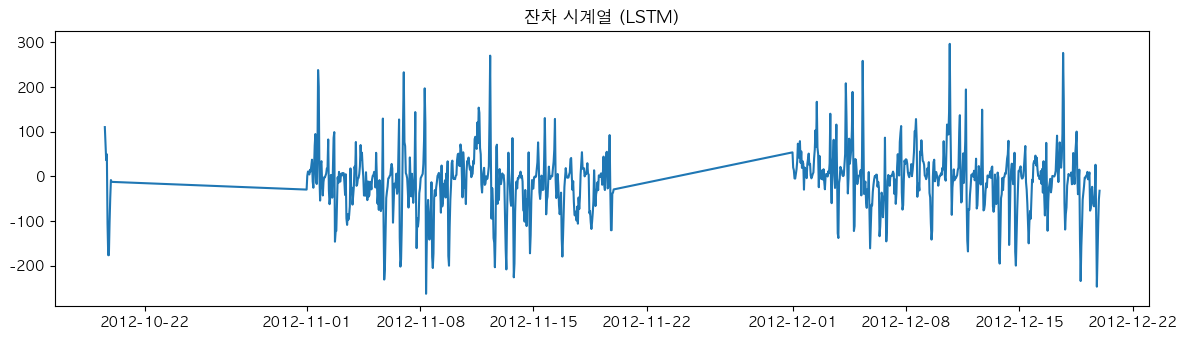

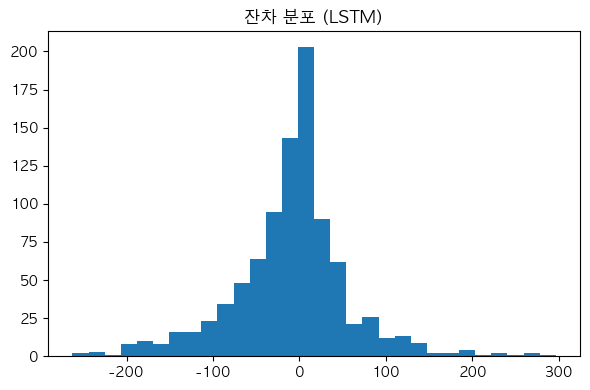

In [ ]:
def compute_metrics(y_true, y_pred):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    mse = float(np.mean((y_true - y_pred)**2))
    rmse = float(np.sqrt(mse))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    prev = np.concatenate([[y_true[0]], y_true[:-1]])
    da = float(np.mean((np.sign(y_true - prev) == np.sign(y_pred - prev)).astype(float)))
    return mae, mse, rmse, mape, da

# 로그 타깃 복원 후 평가
if 'use_log_target' in globals() and use_log_target:
    yva_true = np.expm1(yva_seq.squeeze(-1))
    yte_true = np.expm1(yte_seq.squeeze(-1))
    val_pred_eval = np.expm1(val_pred)
    test_pred_eval = np.expm1(test_pred)
else:
    yva_true = yva_seq.squeeze(-1)
    yte_true = yte_seq.squeeze(-1)
    val_pred_eval = val_pred
    test_pred_eval = test_pred

print('LSTM/VAL', compute_metrics(yva_true, val_pred_eval))
print('LSTM/TEST', compute_metrics(yte_true, test_pred_eval))

# 잔차 분석(복원된 스케일 기준)
residual = yte_true - test_pred_eval
plt.figure(figsize=(12,3.5))
plt.plot(test_idx, residual)
plt.title('잔차 시계열 (LSTM)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('잔차 분포 (LSTM)')
plt.tight_layout(); plt.show()


### 5. 강의 요약 및 다음 단계
- 윈도우 기반 시퀀스 모델의 장단점
- 베이스라인 대비 개선 포인트 및 추가 실험 아이디어(스택드 LSTM, Dropout, 다중 스텝 예측)


### 3-1. 클래스 없이 구현한 LSTM 학습 루프(대안)
- 사용자 정의 `nn.Module` 클래스를 만들지 않고, `nn.LSTM`과 `nn.Linear` 인스턴스를 직접 사용
- 데이터셋도 `TensorDataset`으로 간단히 구성
- 기존 코드와 공존하며, 비교/참고용으로 실행 가능


In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 준비: 윈도우 데이터(X*_seq, y*_seq)와 표준화 통계(mean, std)는 기존 셀에서 생성됨
# Xtr_seq:[N,T,F], ytr_seq:[N] (또는 [N,1]) 가정

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# 디바이스 선택(MPS 비활성 시 CPU)
_device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# 텐서 변환 및 데이터로더 구성
_Xtr = to_tensor(Xtr_seq).to(_device)
_ytr = to_tensor(ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq).to(_device)
_Xva = to_tensor(Xva_seq).to(_device)
_yva = to_tensor(yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq).to(_device)
_Xte = to_tensor(Xte_seq).to(_device)
_yte = to_tensor(yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq).to(_device)

train_ds2 = TensorDataset(_Xtr, _ytr)
val_ds2   = TensorDataset(_Xva, _yva)
test_ds2  = TensorDataset(_Xte, _yte)

train_dl2 = DataLoader(train_ds2, batch_size=128, shuffle=False, drop_last=True)
val_dl2   = DataLoader(val_ds2,   batch_size=256, shuffle=False)
test_dl2  = DataLoader(test_ds2,  batch_size=256, shuffle=False)

# 모델 인스턴스(클래스 정의 없이)
input_size = _Xtr.shape[-1]
hidden_size = 64
num_layers = 1

lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).to(_device)
head2 = nn.Linear(hidden_size, 1).to(_device)

params2 = list(lstm2.parameters()) + list(head2.parameters())
optim2 = torch.optim.Adam(params2, lr=1e-3)
crit2 = nn.MSELoss()

# 순전파 함수

def forward_step2(x_batch: torch.Tensor) -> torch.Tensor:
    out, _ = lstm2(x_batch)
    last = out[:, -1, :]
    pred = head2(last).squeeze(-1)
    return pred

# 학습 루프

def train_epoch2(loader: DataLoader) -> float:
    lstm2.train(); head2.train()
    total, n = 0.0, 0
    for xb, yb in loader:
        optim2.zero_grad(set_to_none=True)
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        loss.backward()
        optim2.step()
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

@torch.no_grad()
def eval_mse2(loader: DataLoader) -> float:
    lstm2.eval(); head2.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

best_state2 = None
best_val2 = float('inf')
for ep in range(1, 11):
    tr = train_epoch2(train_dl2)
    va = eval_mse2(val_dl2)
    print(f'[NoClass] Epoch {ep:02d} | train MSE {tr:.4f} | val MSE {va:.4f}')
    if va < best_val2:
        best_val2 = va
        best_state2 = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm2.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head2.state_dict().items()},
        }

# 베스트 로드
if best_state2 is not None:
    lstm2.load_state_dict(best_state2['lstm'])
    head2.load_state_dict(best_state2['head'])

# 예측
@torch.no_grad()
def predict_all2(loader: DataLoader) -> np.ndarray:
    lstm2.eval(); head2.eval()
    outs = []
    for xb, _ in loader:
        pred = forward_step2(xb)
        outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)

val_pred2 = predict_all2(val_dl2)
test_pred2 = predict_all2(test_dl2)

# 간단한 성능 확인
from math import sqrt
mae2 = float(np.mean(np.abs((_yva.cpu().numpy()) - val_pred2)))
rmse2 = sqrt(float(np.mean(((_yva.cpu().numpy()) - val_pred2)**2)))
print('[NoClass] VAL MAE/RMSE:', round(mae2, 3), round(rmse2, 3))



[NoClass] Epoch 01 | train MSE 11.9627 | val MSE 1.7784
[NoClass] Epoch 02 | train MSE 1.9208 | val MSE 1.3761
[NoClass] Epoch 03 | train MSE 1.2818 | val MSE 0.8820
[NoClass] Epoch 04 | train MSE 0.8346 | val MSE 0.5418
[NoClass] Epoch 05 | train MSE 0.5948 | val MSE 0.4155
[NoClass] Epoch 06 | train MSE 0.4813 | val MSE 0.3263
[NoClass] Epoch 07 | train MSE 0.4157 | val MSE 0.2868
[NoClass] Epoch 08 | train MSE 0.3780 | val MSE 0.2633
[NoClass] Epoch 09 | train MSE 0.3559 | val MSE 0.2477
[NoClass] Epoch 10 | train MSE 0.3455 | val MSE 0.2356
[NoClass] VAL MAE/RMSE: 0.38 0.485
